# Adaptive Binning Examples



In [1]:
ciaover 
echo Today is `date`

CIAO 4.11 Wednesday, December  5, 2018
  bindir      : /export/ciao-4.11/bin
  CALDB       : 4.8.2
Today is Tue Jan 15 10:05:57 EST 2019


The following routines are available in `CIAO` to perform
adaptive binning

- [`dmnautilus`](http://cxc.harvard.edu/ciao/ahelp/dmnautilus.html) : simple quad-tree algorithm


The following are available on github as `python` scripts

- `contour_map` : follows local contours
- `dragon_scales` : overlapping shapes
- `grow_from_max` : watershed tesselations
- `hexgrid` : regular hexagonal grid
- `mkregmap` : stack of regions to a map
- `pathfinder` : steepest ascent 

There is also 

- `merge_too_small` : utility tool to help simplify the output.




These are compiled `C` tools that available on separate github repros that need to be built into your `CIAO` instalation.

- `dmnautilus` : upgrade to allow for lower threshold limits
- `dmradar` : elliptical-polar equivalent of `dmnautilus`

## Getting Started

We'll start by downloading and reprocessing the data.  We'll also grab a custom colormap to make the display more interesting and setup a helper routine to display `ds9` images in the notebook.


In [2]:
# Get a custom color map from CPT-CITY, now in ds9.sao format
curl -O http://soliton.vm.bytemark.co.uk/pub/cpt-city/neota/othr/sunset-in-atlantis.sao

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
112   673  112   673    0     0   4492      0 --:--:-- --:--:-- --:--:--  9094


In [3]:
###download_chandra_obsid 9399 evt1,asol,bpix,bias,dtf,flt,fov,msk,mtl,pbk,stat

In [4]:
###chandra_repro 9399 9399/repro 2>&1 | sed s,`pwd`,.,g

In [5]:
# Create image for just CCD_ID=7
apply_fov_limits \
     infile="9399/repro/acisf09399_repro_evt2.fits[ccd_id=7,energy=200:2000]" \
     outfile=img.fits binsize=4 cl+

Running: apply_fov_limits
  version: 12 September 2016
Observation: ObsId 9399 - ACIS-23567
Using ccd_id=7 from 9399/repro/acisf09399_repro_evt2.fits[ccd_id=7,energy=200:2000]
Calculating FOV file using:
  Aspect solution 9399/repro/pcadf321296841N002_asol1.fits
  Mask file       9399/repro/acisf09399_000N002_msk1.fits

The output image will have 364 by 366 pixels, pixel size of 1.968 arcsec,
    and cover x=3532.5:4988.5:4,y=3092.5:4556.5:4.

Created: img.fits


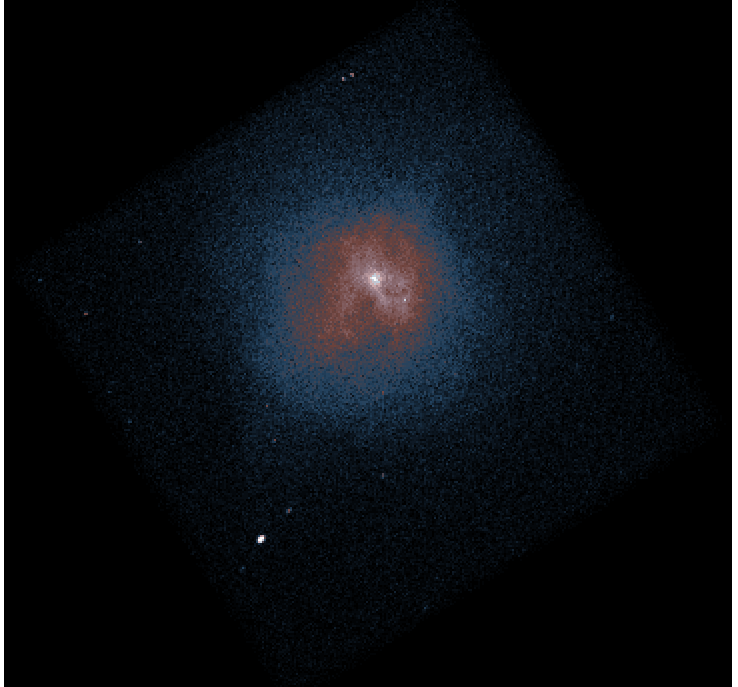

In [6]:
ds9 -scale asinh -scale limits 0 200 -zoom 2 -cmap load sunset-in-atlantis.sao  \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  img.fits \
  -saveimage png img.png -quit 

display < img.png

The updated version of the tool also respects the image subspace.  We can filter the image with 
field-of-view file, with `[opt full]` to retain the dimensions to _set_ the subspace in the image.

In [7]:
# Get FOV for just CCD_ID=7
dmcopy "9399/repro/acisf09399_repro_fov1.fits[ccd_id=7]" ccd7.fov clob+

In [8]:
dmcopy "img.fits[sky=region(ccd7.fov)][opt full]" img.dss.fits clob+

In [9]:
# Routine to display images using ds9 in notebook
display_map()
{
img=$1
map=$2
png=$3

ds9 -geom 1550x824 -scale asinh -scale limits 0 200 \
  -zoom 2 -cmap load sunset-in-atlantis.sao  \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  $img \
  -frame new -cmap load $ASCDS_INSTALL/contrib/data/16_ramps.lut \
  $map -scale linear -scale mode minmax \
  -regions select all -regions color black -regions select none \
  -tile yes \
  -saveimage png $png -exit 

display < $png
}

In [10]:
/bin/rm -rf ./tmp
mkdir ./tmp
ASCDS_WORK_PATH=`pwd`/tmp

---

## `dmnautilus`

[`dmnautilus`](http://cxc.harvard.edu/ciao/ahelp/dmnautilus.html) is a compiled tool in CIAO. It implements a quad-tree adaptive bin algorithm. If the SNR in the image values is above the input threshold, the image is divided into 2x2. Each sub-image is then checked. The algorithm stops when SNR threshold is no longer met and/or single pixel remains.


### Example

Keeps sub-dividing the image until the SNR falls below 15.8 (~300 counts).



In [11]:
dmnautilus img.dss.fits nautilus.img 15.8 outmask=nautilus.map clob+

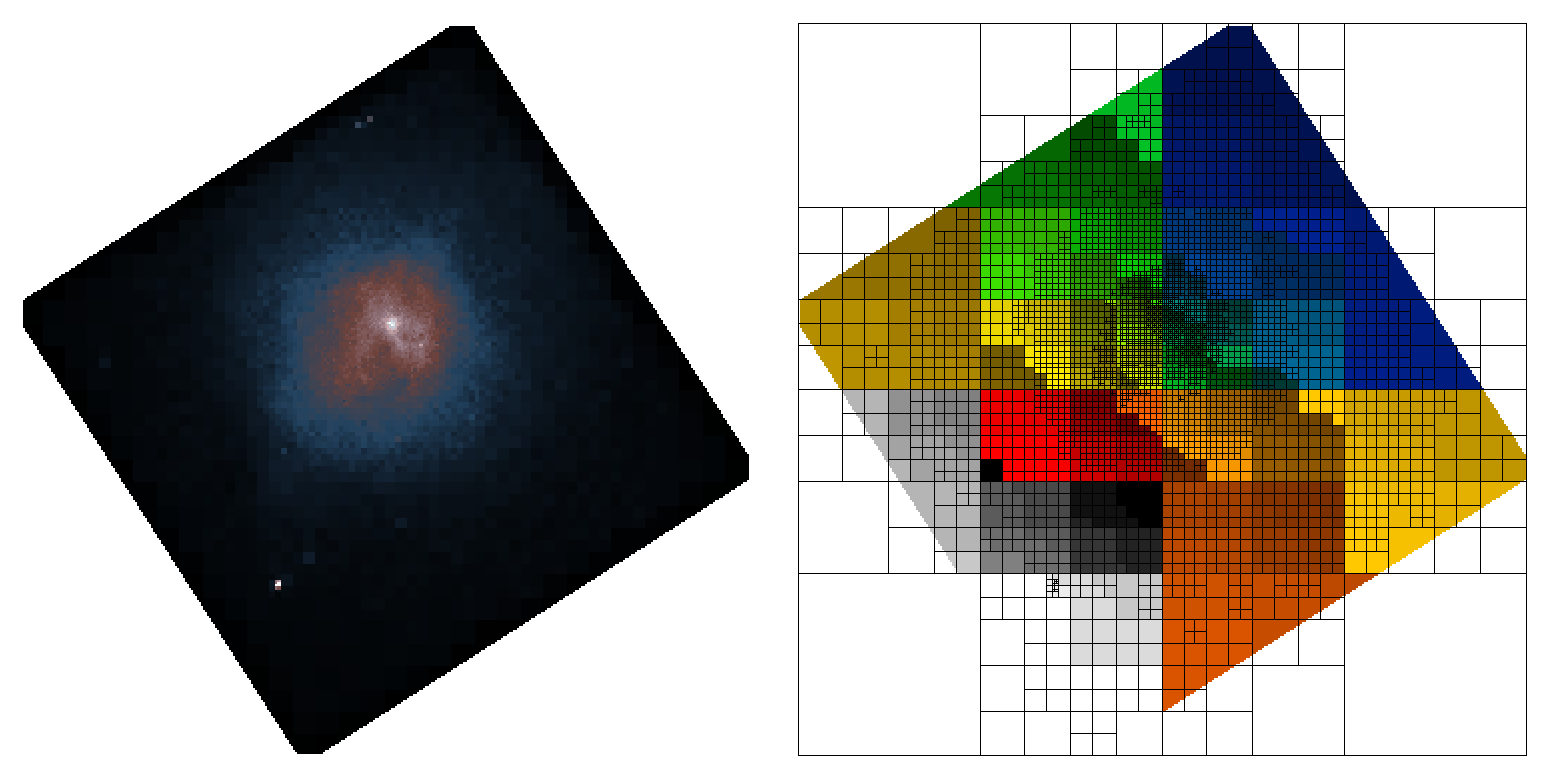

In [12]:
# Left if adaptively binned image, right is the map file
display_map nautilus.img nautilus.map nautilus.png

We see that the center of the image is almost entirely ungrouped.

> Note: Unlike some of the algorithms below, the input image does not need to be smoothed.


---
## `contour_map`

A nod to Sanders' `contour_bin` routine  [arXiv:astro-ph/0606528](https://arxiv.org/abs/astro-ph/0606528) . Uses [`dmimglasso`](http://cxc.harvard.edu/ciao/ahelp/dmimglasso.html) to generate a contour around the max value down to next lowest value in the contour grid. Uses a maximum radius criteria to prevent thin, long “fingers”. Repeats until all pixels are included.

This routine works best with a smoothed input image.


### Example

Create upto 100 contour levels from the min pixel value to the max
pixel value, spaced logarithmatically.  The contours are resticted to
stay within a 500 physical pixel radius circle of the starting point, and at most 150 contours will be created.


In [13]:
# Smooth image with simple 3-pixel sigma Gaussian
aconvolve img.dss.fits smimg.fits kernels="lib:gaus(2,5,5,3,3)"  \
  method=slide edges=constant const=0 clob+

In [14]:
contour_map infile=smimg.fits outfile=cbin.map binimg=cbin.img \
  distance=500 shape=circle levels=100 scale=log maxcontours=150 \
  verbose=1 clobber=yes  

contour_bin
          infile = smimg.fits
         outfile = cbin.map
          binimg = cbin.img
        distance = 500
           shape = circle
          levels = 100
           scale = log
     maxcontours = 150
         verbose = 1
         clobber = yes
            mode = ql

Contour lower limit: 90.05286173188391
Contour lower limit: 64.34516384838473
Contour lower limit: 45.97633024703298
Contour lower limit: 45.97633024703298
Contour lower limit: 32.85131028596014
Contour lower limit: 32.85131028596014
Contour lower limit: 23.473134582638327
Contour lower limit: 23.473134582638327
Contour lower limit: 23.473134582638327
Contour lower limit: 23.473134582638327
Contour lower limit: 23.473134582638327
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lower limit: 16.77217871489688
Contour lo

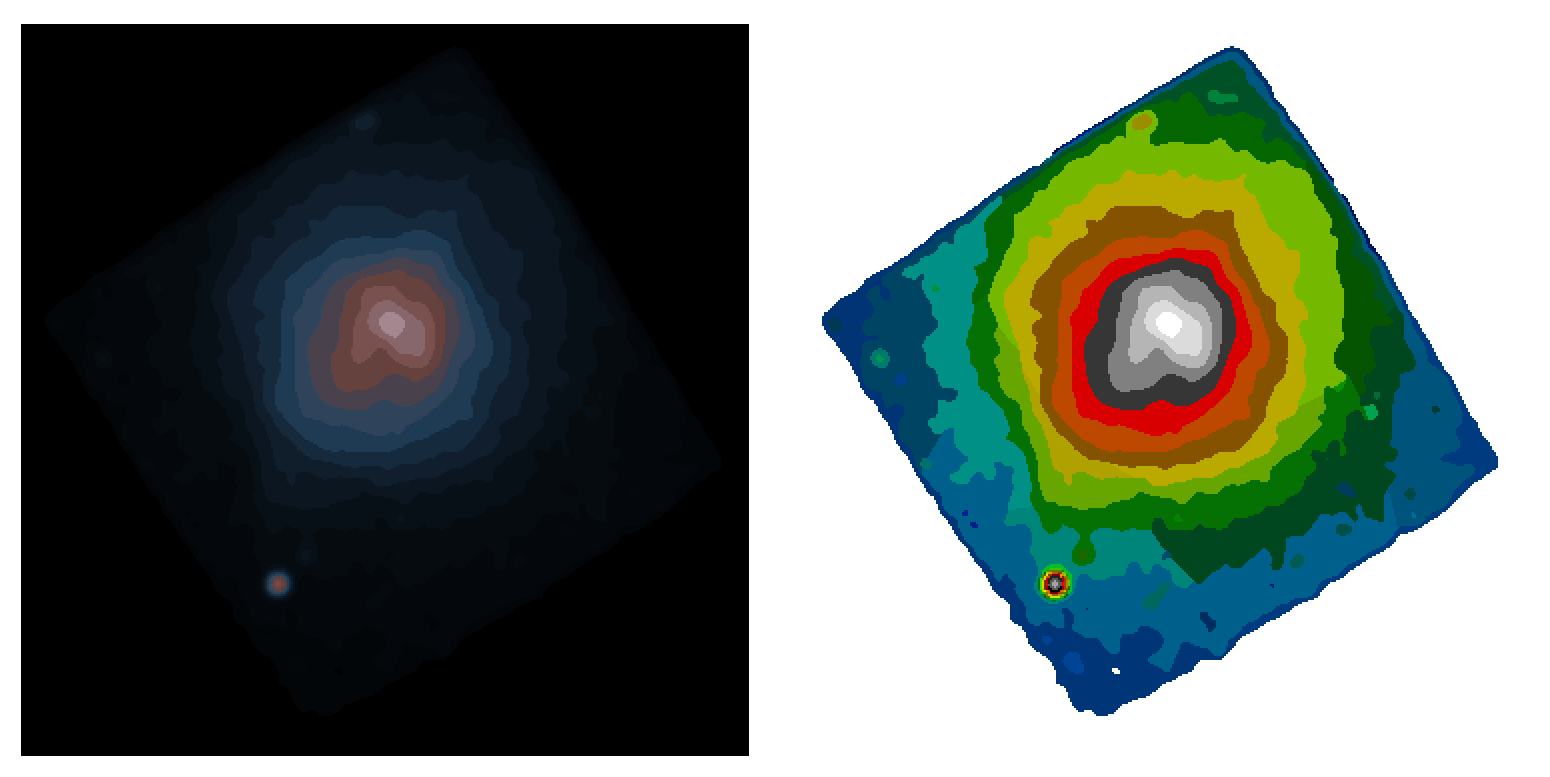

In [15]:
display_map cbin.img cbin.map cbin.png

Because we choose a maximum of 150 contours parts of the image is ungrouped.  There are many small groups around the bright point-like source.

This algorithm works better when the input is heavily smoothed, or when point-like source have been filled.

---
## `dragon_scales`

Start at the max pixel value in image and group the ungrouped pixels within input radius. Goto the next highest pixel value not already included in a group and repeat. The radius can be a fixed value used for all pixels or taken from input image.

### Example 1, fixed radius



In [16]:
dragon_scales smimg.fits psf=10 outfile=ds_10px.map \
  binimg=ds_10px.img shape=circle clobber=yes

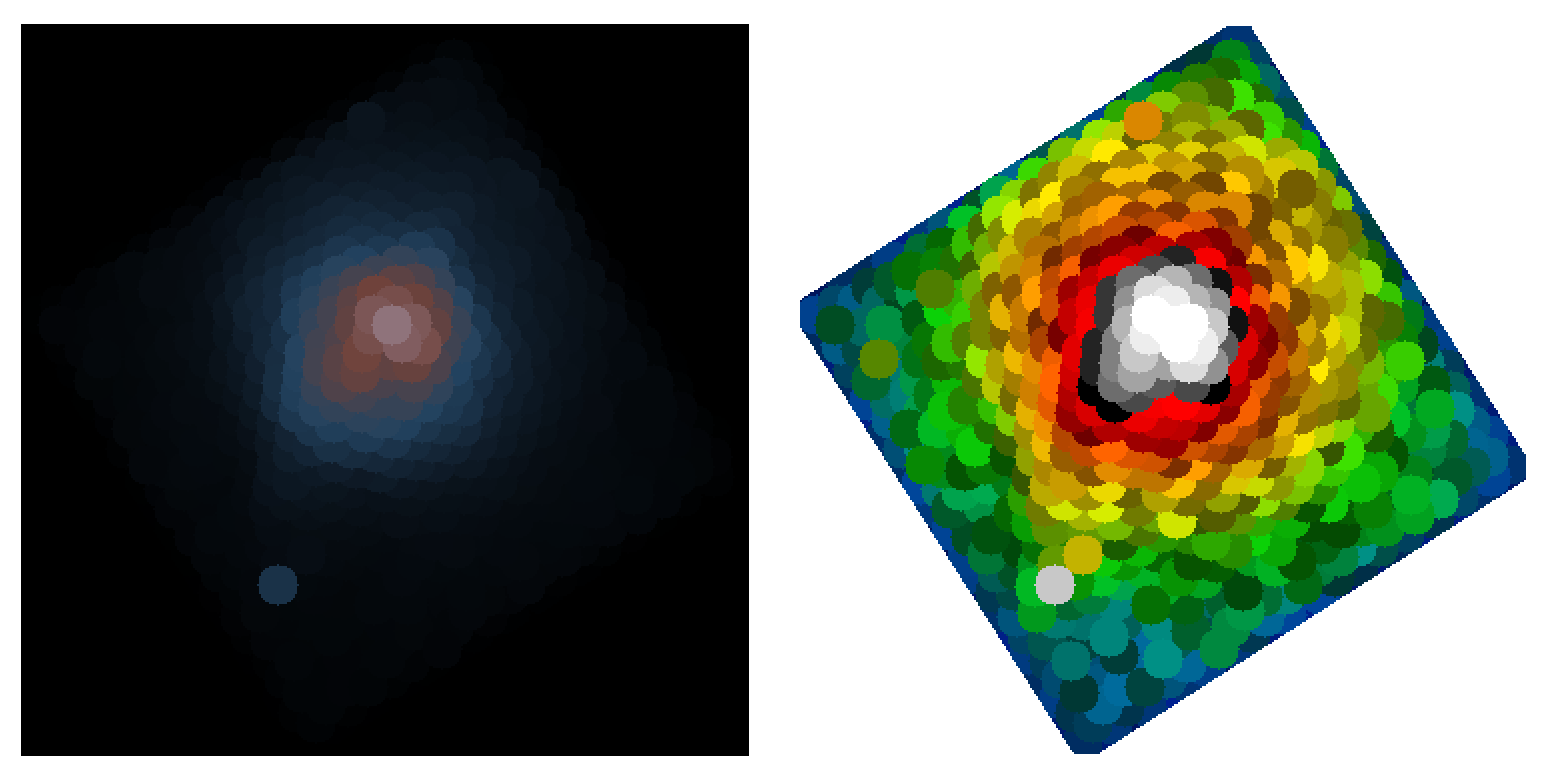

In [17]:
display_map ds_10px.img ds_10px.map ds_10px.png


Users will find many small groups filling in the gaps between larger ones.  This can be adjusted later
using the `merge_too_small` scripts (below)



### Example 2, variable radius

In this example we create an input radius map.  The radius map is create such that a circle at
each pixel with a radius equal to the pixel value will contain at least 500 counts, with a 
maximum radius of 100 pixels.

This radius map is then input to `dragon_scales`

In [18]:
dmimgadapt img.dss.fits img_500.asm tophat min=1 max=100 numrad=100  \
  radscale=lin counts=500 radfile=min500.map verb=2 clob+

Pre-computing convolution kernels
First iteration: determine scales and normalization

Second iteration: computing final normalized values


In [19]:
dragon_scales smimg.fits min500.map out=ds_500cts.map  \
  binimg=ds_500cts.img clob+

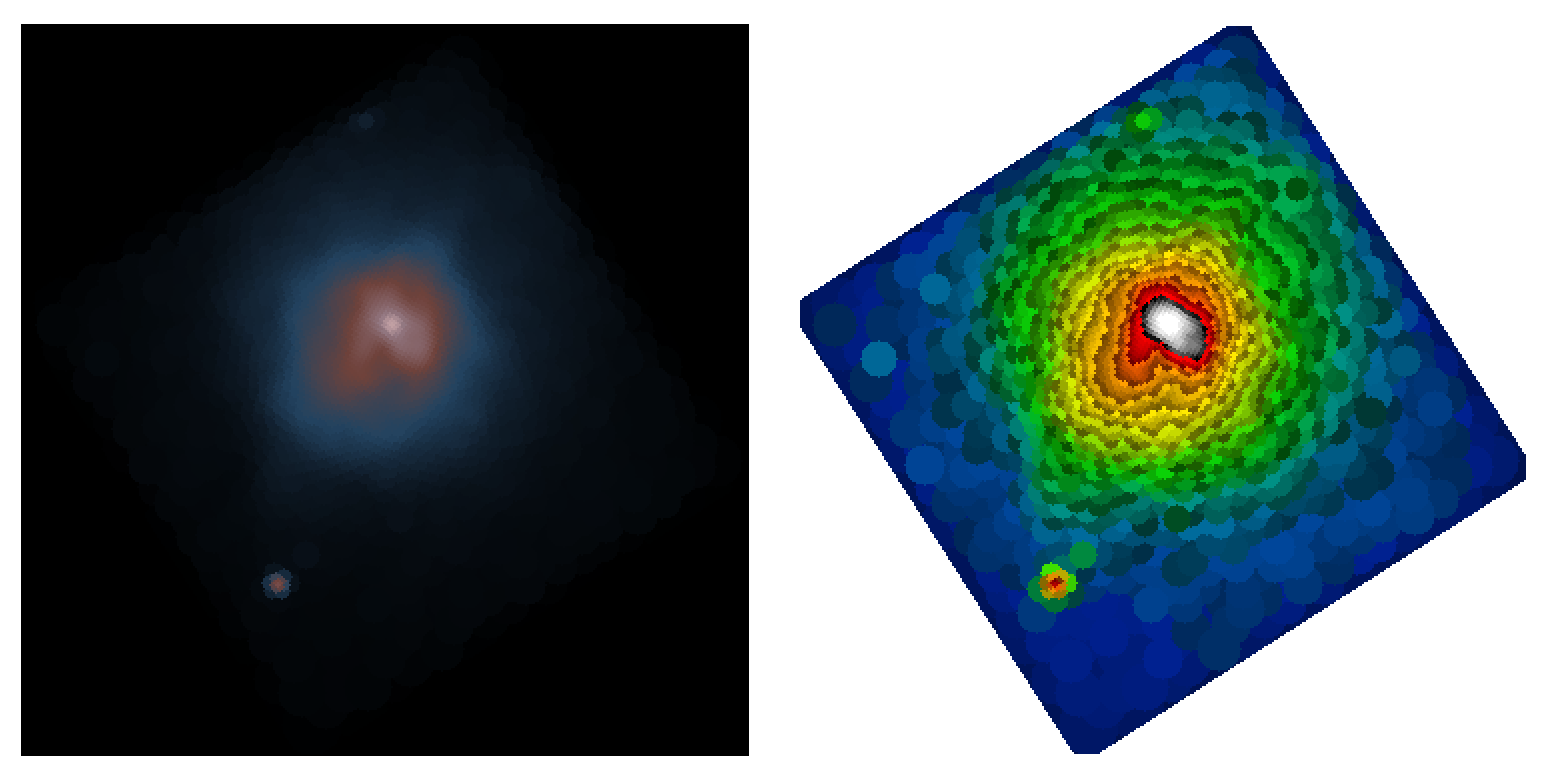

In [20]:
display_map ds_500cts.img ds_500cts.map ds_500cts.png

The same effects are seen in the variable radius compared to the fixed radius input.

Note: in the case of the radius map input, the smoothing is not guaranteed to contain at least 500 counts when smoothing since the groups are not allowed to overlap.

This algorithm does not require that the input image be smoothed.


---

## `grow_from_max`

This script starts by using [`dmimgfilt`](http://cxc.harvard.edu/ciao/ahelp/dmimgfilt.html) to find the location of the local maximums. Each local max pixel is given a unique ID ([`dmimgblob`](http://cxc.harvard.edu/ciao/ahelp/dmimgblob.html)), and then is dilated until it hits its neighbors. This is basically a watershed transform or can also be thought of as a tessellation.

The infile should be smoothed but not overly smooth. The input should have a large number of local maximums but not so many that every other pixel is one. Using an adaptively smoothed image at the size/scale of the PSF seems to work nicely.

The off-chip/edge behavior is especially dramatic for this algorithm. Dealing with pixels outside the FOV should be reviewed.

### Example

Adaptively smooth the input image at the size of the 95% ECF,see [thread](http://cxc.harvard.edu/ciao/threads/ttt_mkpsfmap_smoothing/), and then create the groups based on the 
remaining local maxima. 


In [21]:
# Create PSF map
mkpsfmap img.dss.fits psf.map energy=1 ecf=0.95 units=logical

# Truncate to 1 decimal place (runs faster)
dmimgcalc infile=psf.map infile2=none outfile=ipsf.map\
  operation="imgout=((int)(img1*10.0))/10.0" clob+

# Adaptively smooth
dmimgadapt infile=img.dss.fits outfile=img.psf_asm function=gaussian \
  inradfile=ipsf.map mode=h clob+ verb=1

---

> **There is a bug** in `dmmaskbin` which shows up when running `grow_from_max`. 
> I have a version on my github page with the bug fixed.  
> It only shows up when the input image has pixel values set to $NaN$
> Users can replace the $NaN$ with 0 using `dmimgthresh`
> 
> `dmimgthresh img.psf_asm img.psf_asm.nonan cut=INDEF value=0`

---


In [22]:
grow_from_max img.psf_asm out=watershed.map binimg=watershed.img \
  shape=box rad=2.5 verb=1 clob+

grow_from_max
          infile = img.psf_asm
         outfile = watershed.map
          binimg = watershed.img
           shape = box
          radius = 2.5
        sitefile = 
         verbose = 1
         clobber = yes
            mode = ql

Finding local maxima
Assigning pixels to maxima
Pixels remaining to be mapped : 72617
Pixels remaining to be mapped : 66529
Pixels remaining to be mapped : 55498
Pixels remaining to be mapped : 43619
Pixels remaining to be mapped : 33801
Pixels remaining to be mapped : 26340
Pixels remaining to be mapped : 20692
Pixels remaining to be mapped : 16261
Pixels remaining to be mapped : 12806
Pixels remaining to be mapped : 10159
Pixels remaining to be mapped : 8241
Pixels remaining to be mapped : 6725
Pixels remaining to be mapped : 5480
Pixels remaining to be mapped : 4501
Pixels remaining to be mapped : 3713
Pixels remaining to be mapped : 3050
Pixels remaining to be mapped : 2495
Pixels remaining to be mapped : 2020
Pixels remaining to be mapped : 

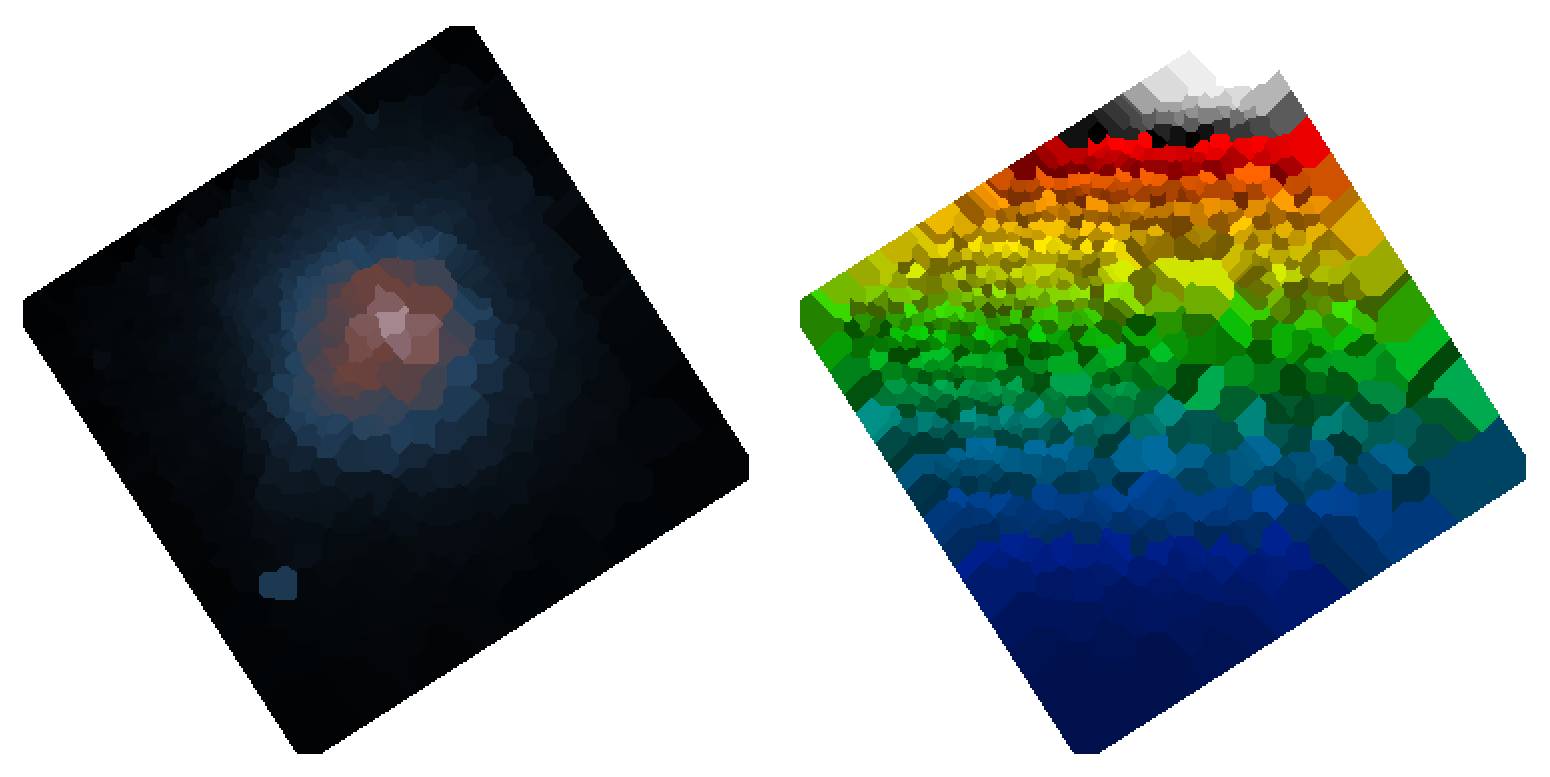

In [23]:
display_map watershed.img watershed.map watershed.png 


The center of each of these _cells_ is a local maximum.  All pixels closest to the local maximum are grouped together.

> There is a possible modification or extension of this algorithm also quasi-prototyped.  The idea is that 
> after the tesselation and grouping is computed, we then compute the centroid of the pixels in each group.
> The algorithm is repeated, replacing the location of the local-maxima with the centroid location.  This 
> repeats until the centroids have converged or **TBD** (max iterations? etc.)   The issue we've seen is that
> we can end up with two centroids in adjacent pixels which we'd like to combined into a single group.  Figuring 
> out how to do that is **TBR** 



---
## `pathfinder`

The `pathfinder` algorithm uses a steepest ascent algorithm to group pixels.  For any given pixel, the algorithm checks the surrounding pixels for the maximum value; the current pixel and the pixel with the maximum value are grouped.  Then this is then repeated for the pixel with the maximum value.  It stops when the current pixel is the local maximum in the neighborhood.


### Example

In [24]:
pathfinder img.psf_asm outfile=pathfinder.map minval=0.2 clob+

pathfinder
          infile = img.psf_asm
         outfile = pathfinder.map
          minval = 0.2
       direction = diagonal
        debugreg = 
         verbose = 1
         clobber = yes
            mode = ql



In [25]:
# Unlike the other tools, `pathfinder` doesn't create the binned image
dmmaskbin img.fits pathfinder.map pathfinder.img clob+

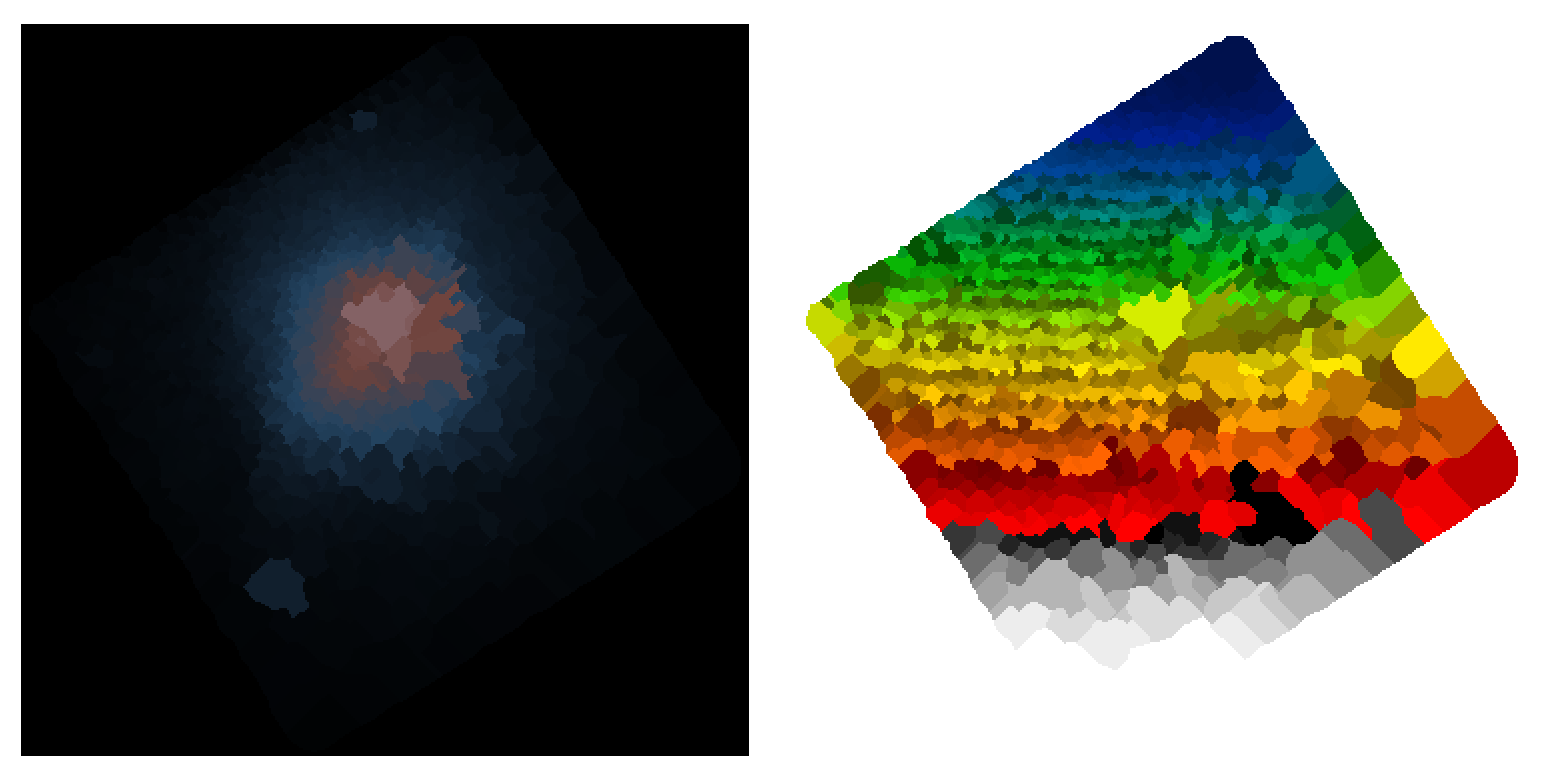

In [26]:
display_map pathfinder.img pathfinder.map pathfinder.png

This algorithm is similar to `grow_from_max`, except instead of relying on the distance from a pixel to the local-max, it relies on the gradient to the local maximum.  This allows say two point sources to separate at the saddle point between them rather than at a fixed distance.

Again, this works best when the input image has been smoothed such that the local max and gradients are meaningful.

---
## `hexgrid`

The hexgrid routine is not adaptive but simply creates a grid of hexagonal shaped masks. Hexagons are a natural tiling element. They are the regular polygon with the most number of sides that can uniformly tile an image. As such they are the closest approximation to circular grid.

The pixel values in the infile are not used to create the grid; only the image dimensions.

As sidelen becomes small, there can be some quantization like effects/rough edges. A practical limit of 3 pixel is used.

The xref,yref location basically sets the “phase” of the hexagonal grid. It provides a way to keep the grid from spiting a single feature into multiple adjoining grids.

### Example

In [27]:
# Determine the location of the centroid in logical pixel coordinates
dmstat smimg.fits cen-
px=`stk_read_num ")dmstat.out_max_loc" 1 echo+`
py=`stk_read_num ")dmstat.out_max_loc" 2 echo+`
dmcoords smimg.fits op=sky x=$px y=$py

CONVOLVE
    min:	0.0066826618277 	      @:	( 4438.5 4550.5 )
    max:	126.03153992 	      @:	( 4274.5 3954.5 )
   mean:	6.624006713 
  sigma:	10.931784032 
    sum:	486056.36459 
   good:	73378 
   null:	59846 


In [28]:
hexgrid img.dss.fits hex.map side=10 bin=hex.img \
  xref=")dmcoords.logicalx" yref=")dmcoords.logicaly" clob+

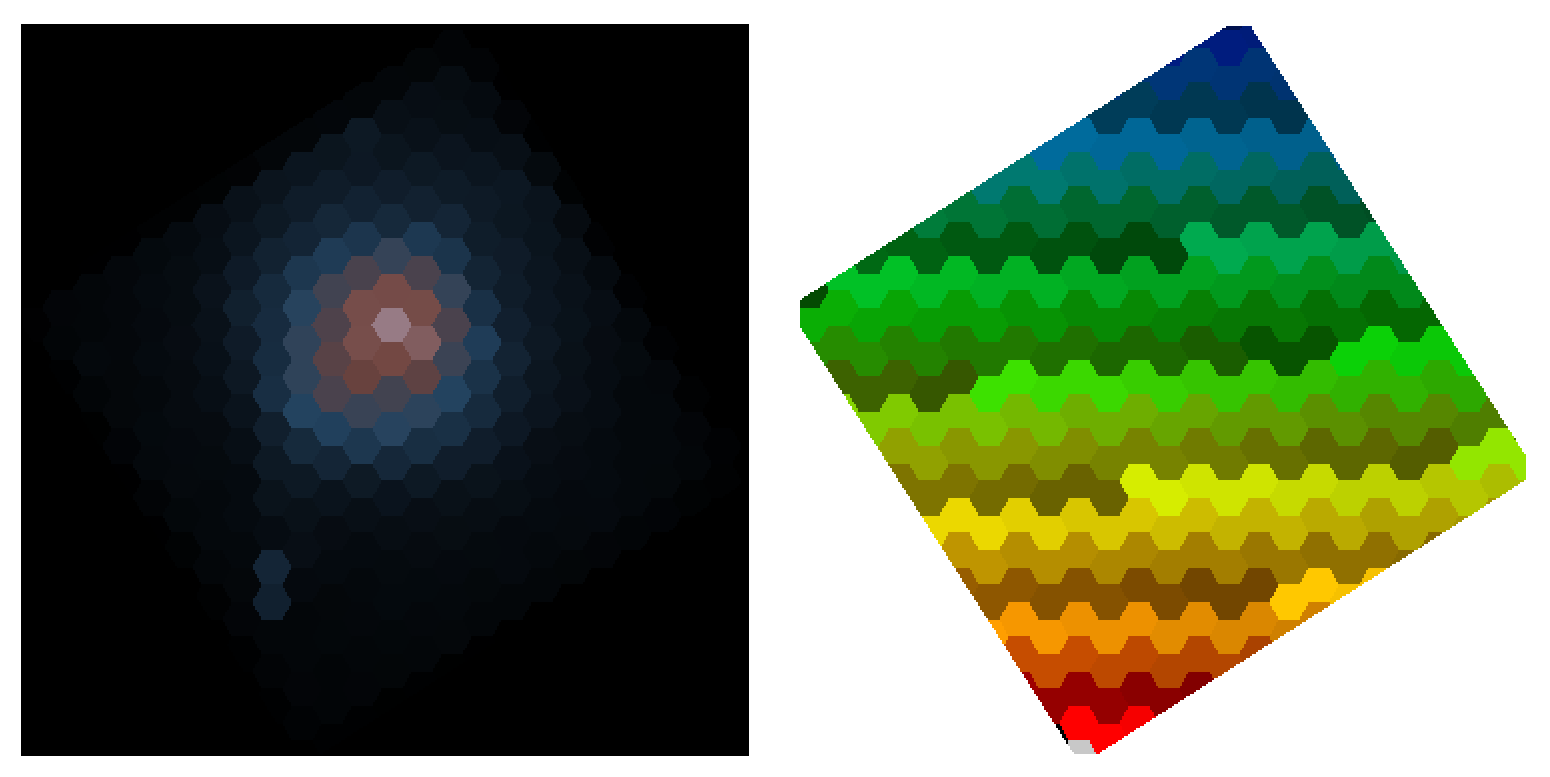

In [29]:
display_map hex.img hex.map hex.png

> **TBD** we could also rotate the hexagons +/-90 deg 

---
## `mkregmap`

This script reads in a stack of regions (1 to N) and labels the pixels in the output map based on which region they belong to. In the case of overlaps, the last (highest N) is used.

### Example 1, regular polar grid

In [30]:
dmstat smimg.fits cen- verb=0
set px = `stk_read_num ")dmstat.out_max_loc" 1 echo+`
set py = `stk_read_num ")dmstat.out_max_loc" 2 echo+`

In [31]:
mkregmap img.dss.fits out=pie.map bin=pie.img coord=sky clob+ \
  regions="circle(${px},${py},10);pgrid(${px},${py},10:1000:10,0:360:30)"

mkregmap
          infile = img.dss.fits
         regions = circle(4274.5,3954.5,10);pgrid(4274.5,3954.5,10:1000:10,0:360:30)
         outfile = pie.map
          binimg = pie.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



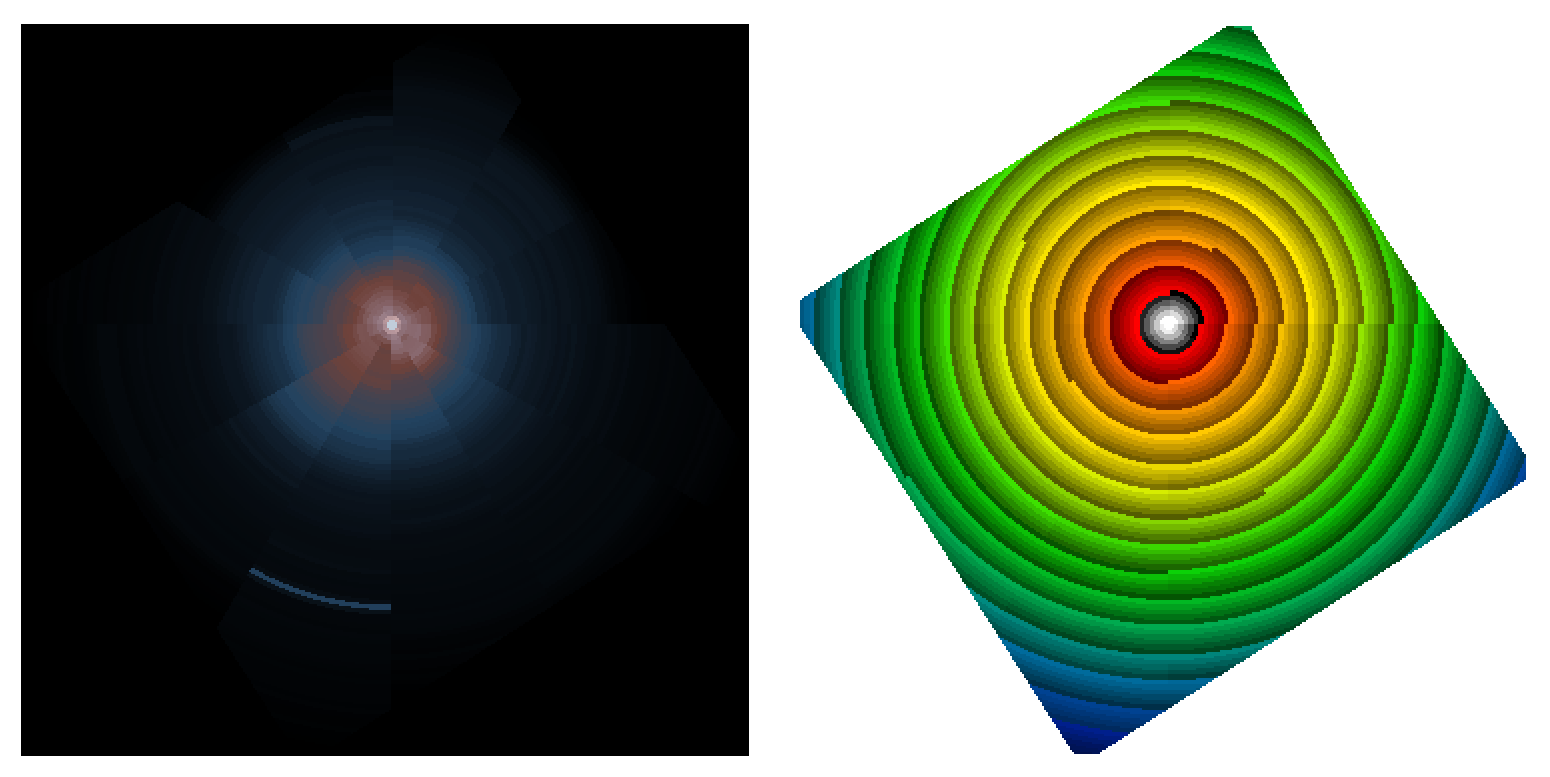

In [32]:
display_map pie.img pie.map pie.png

Again, this isn't really _adaptive_ in the same was as other algorithms; but is shown here to illustrate the use of
stacks of regions using the `pgrid` syntax.

### Example 2, isophot-ellipse

In this example we use [`dmellipse`](http://cxc.cfa.harvard.edu/ciao/ahelp/dmellipse.html) to create a set of ellipses which enclose from 5% to 100% of the counts in the image in 2.5% increments.  These ellipses are then used as 
input to `mkregmap`


In [33]:
dmellipse infile=img.fits outfile=ellipses.fits  \
  fraction="lgrid(0.05:1.0:0.025)" shape=ellipse clob+ step=20 verb=1

# We need to reverse order so that smallest fraction is last region in file
# since the last region a pixel is used when there are overlaps.
dmsort ellipses.fits ellipses_sort.fits -component clob+

In [34]:
mkregmap infile=img.dss.fits outfile=ellipse.map bin=ellipse.img clob+ \
  regions='ellipses_sort.fits[#row=igrid(1:100:1)]'

mkregmap
          infile = img.dss.fits
         regions = ellipses_sort.fits[#row=igrid(1:100:1)]
         outfile = ellipse.map
          binimg = ellipse.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



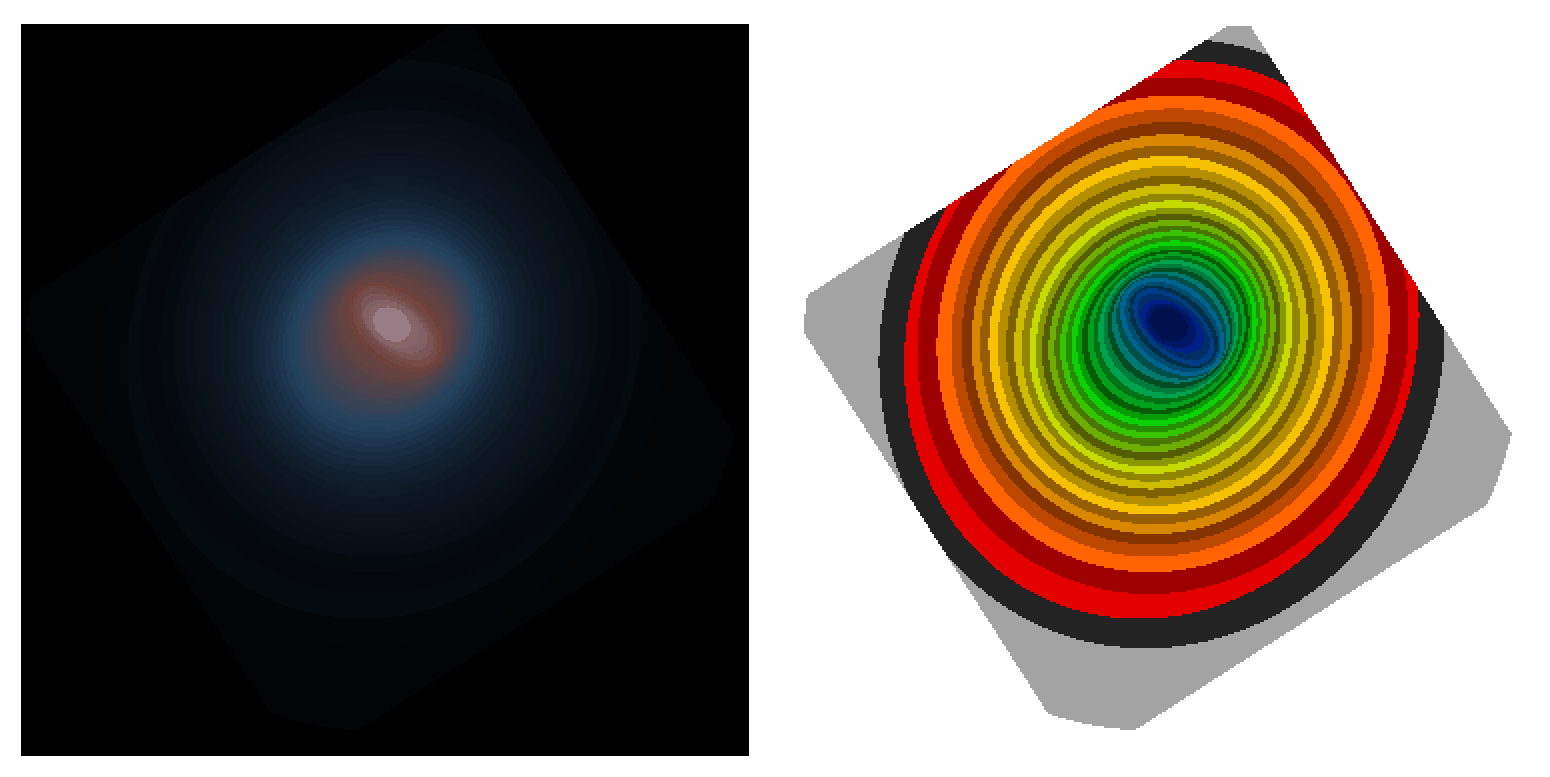

In [35]:
display_map ellipse.img ellipse.map ellipse.png

We sorted the `dmellipse` output file so that the inner ellipses (smaller fraction) are last.


---
---

## `dmnautilus` mark 2

Inverts the SNR threshold logic – that is
to make the SNR be a lower-limit rather than an
upper limit. The new algorithm will only split the region
into 2x2 if one, or more of the sub-regions exceeds
the SNR threshold. The new `method` parameter
controls behavior. `method=0` is the original
algorithm. `method=4` requires all 4 sub images to
exceed the SNR limit.

```bash
git clone https://github.com/kglotfelty/dmnautilus-
```

Contact me for build instructions.


### Example `method=0` (original)

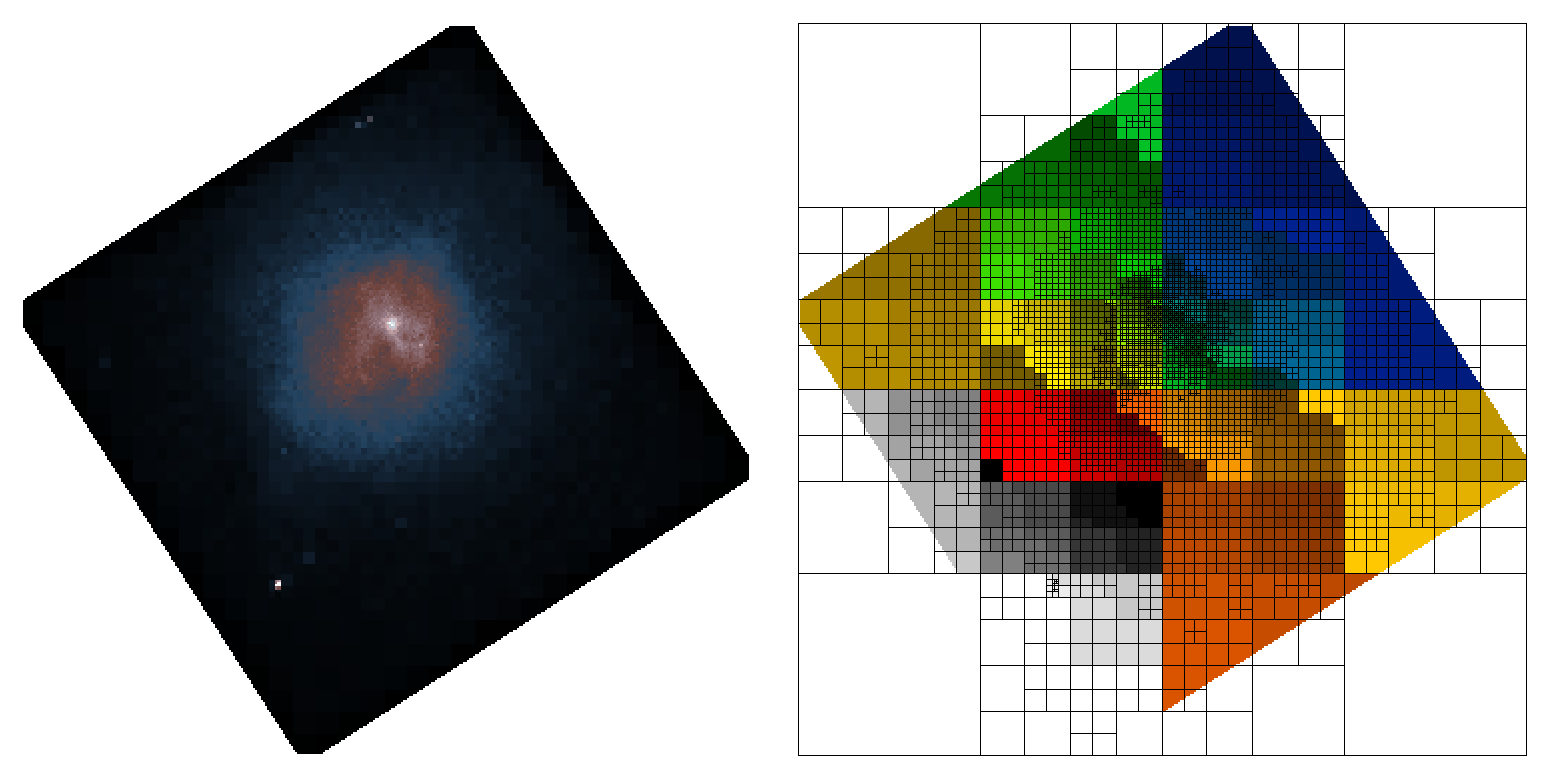

In [36]:
dmnautilus img.dss.fits nautilus.0.img 15.8 outmask=nautilus.0.map method=0 clob+
display_map nautilus.0.img nautilus.0.map nautilus.0.png

### Example `method=1:4` 

The `method` parameter controls the number of sub-images in the 2x2 grid which must be above the SNR limit.

- `method=1` requires any 1 of the 2x2 subimages be above the SNR limit.
- `method=2` requires 2 of the 2x2 submiages to be above the SNR limit.  The two must share a side (ie not diagonal)
- `method=3` requires 3 of the 2x2 subimages to be above the SNR limit.
- `method=4` requires all 4 of the 2x2 subimage to be above the SNR limit.

In general, the size of the groups will be smaller for lower method values. 



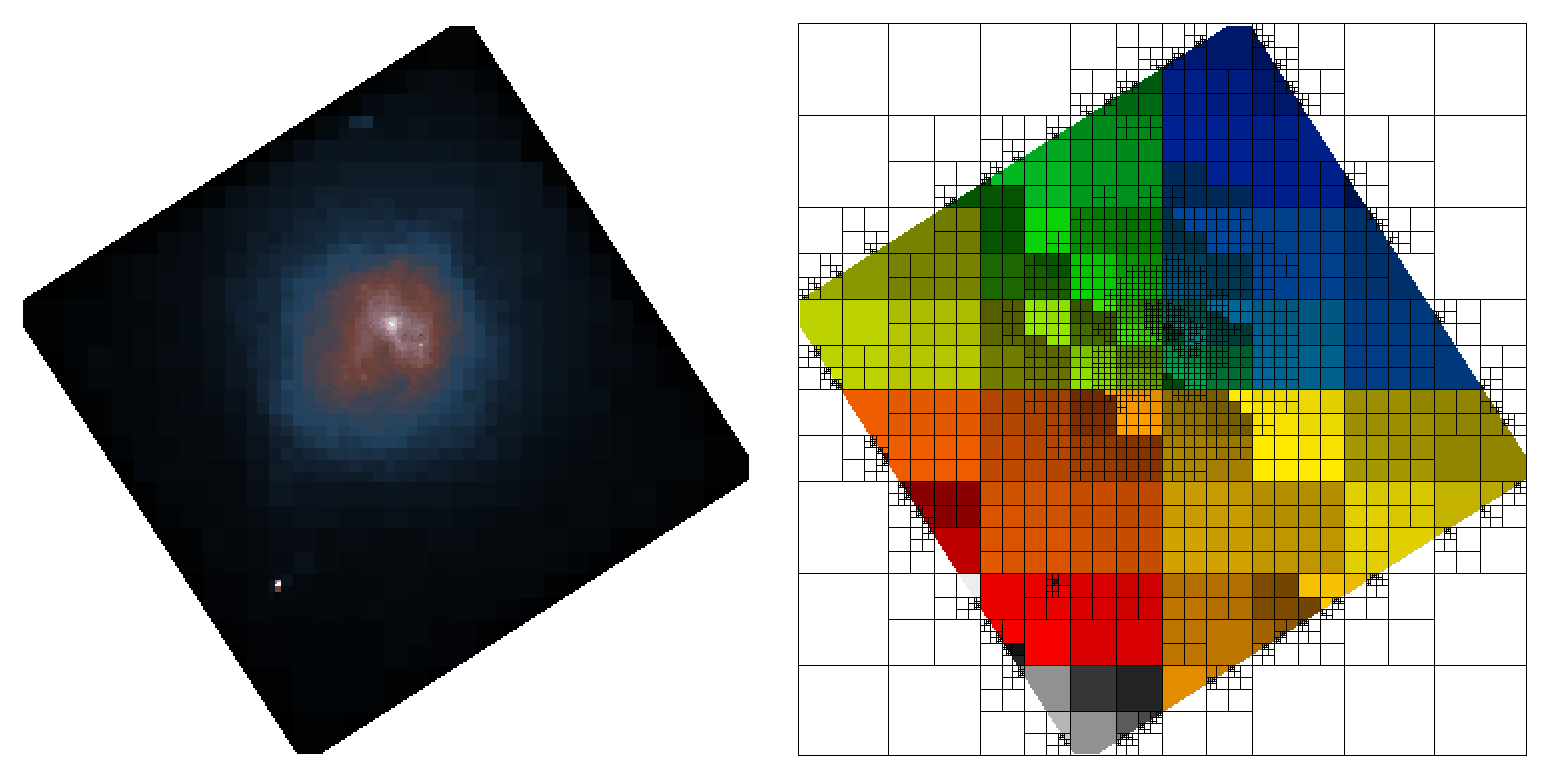

In [37]:
dmnautilus img.dss.fits nautilus.1.img 15.8 outmask=nautilus.1.map method=1 clob+
display_map nautilus.1.img nautilus.1.map nautilus.1.png

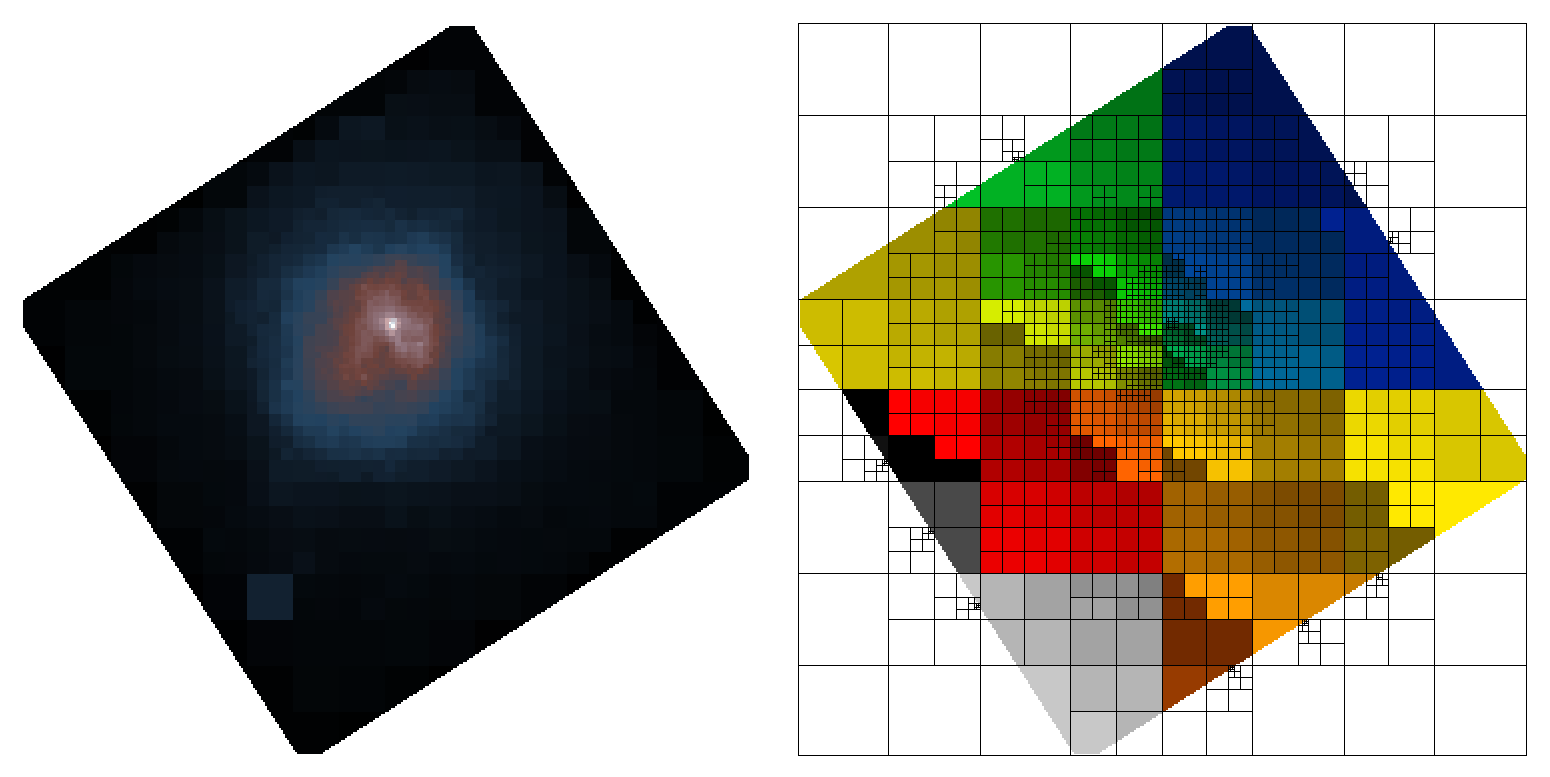

In [38]:
dmnautilus img.dss.fits nautilus.2.img 15.8 outmask=nautilus.2.map method=2 clob+
display_map nautilus.2.img nautilus.2.map nautilus.2.png

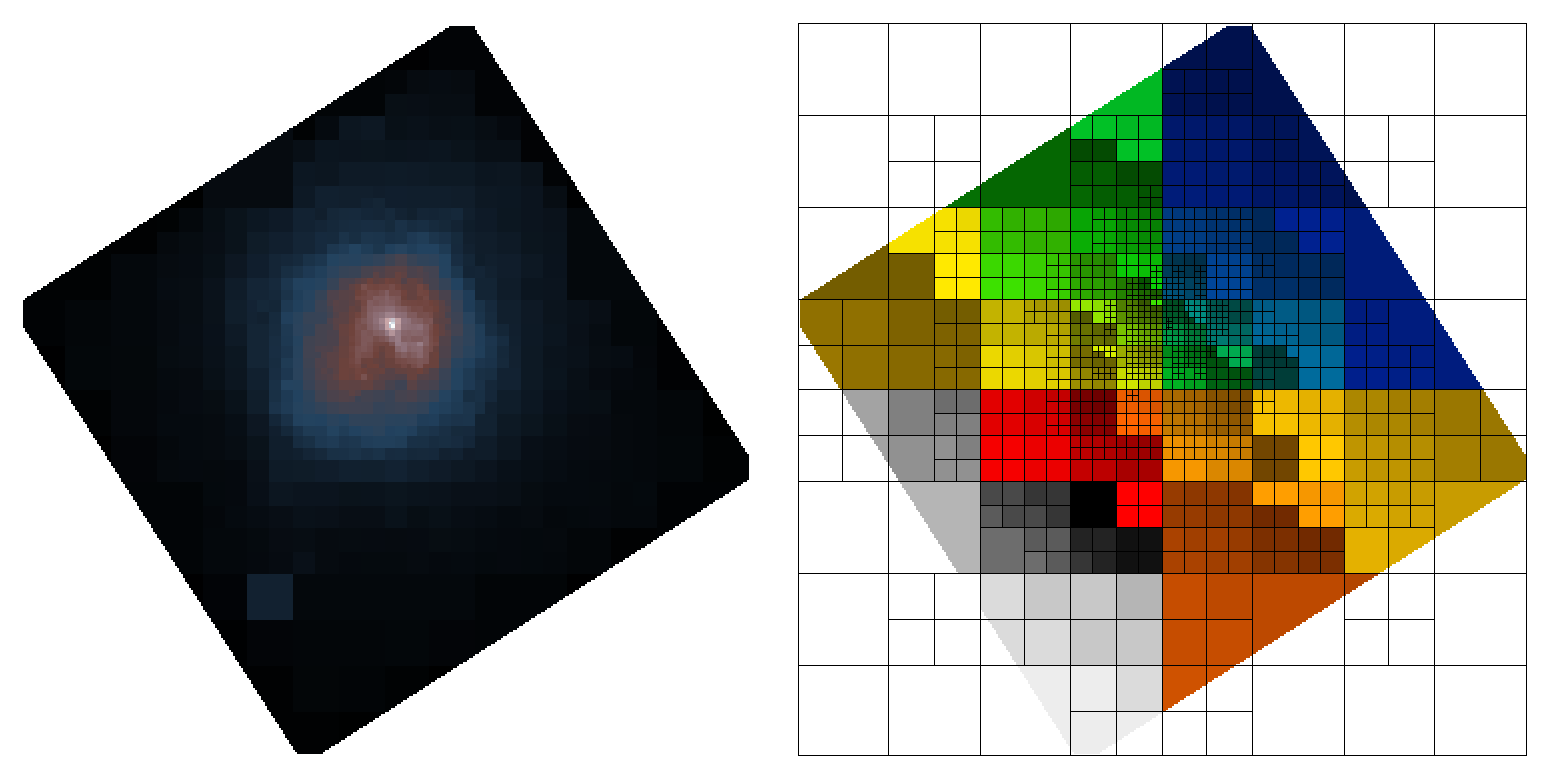

In [39]:
dmnautilus img.dss.fits nautilus.3.img 15.8 outmask=nautilus.3.map method=3 clob+
display_map nautilus.3.img nautilus.3.map nautilus.3.png

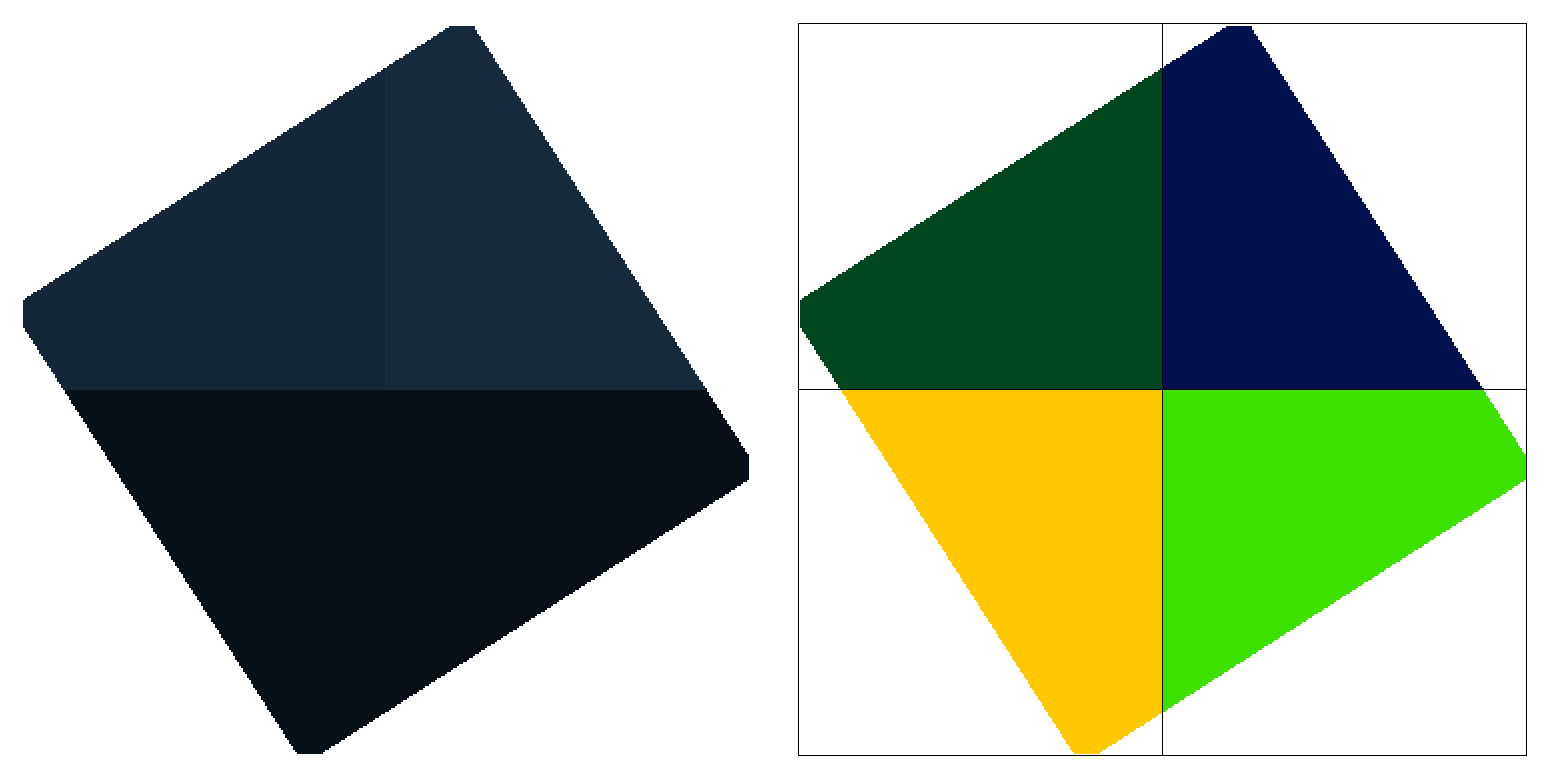

In [40]:
dmnautilus img.dss.fits nautilus.4.img 15.8 outmask=nautilus.4.map method=4 clob+
display_map nautilus.4.img nautilus.4.map nautilus.4.png

For `method=1|2|3` you can see the difference primarily along the edge of the field-of-view.  By allowing the 
SNR to be lower than the SNR, the edge can captured.

Unfortunately, with `method=4`, things become problematic.  The image is subdivided into 2x2, but then is unable to 
subdivide further because of the edge running diagonally through the sub-image.

If the dataset extended to (or past) the edge of the image then this less often a problem.  Similarly, if we rotate the image to align the FOV edge to the image edge then 


### Example, `method=4` with rotated input

To overcome the problems with `method=4`, we need to establish the edge of the field and it
also helps to rotate the image to make the chip edges parallel to the image axes. 

We start by rotating the image.  Luckily, we can rotate by the `ROLL_PNT` value (for a single
OBI image), about the center of the image (in image coordinates) using the [`dmregrid2`](http://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid2.html) tool.

In [41]:
dmkeypar img.fits ROLL_PNT echo+

57.328032904442


In [42]:
dmlist img.fits blocks | grep EVENTS_IMAGE

Block    1: EVENTS_IMAGE                   Image      Int2(364x366)


In [43]:
echo "364/2" | bc 
echo "366/2" | bc

182
183


In [44]:
# Rotate by ROLL_PNT about center to align edge
dmregrid2 img.fits img.rot res=1 method=sum theta=57.328 rotx=182 roty=183 clob+

Next we need to compute the FOV boundary in the rotated image space.  We could probably compute it 
using `dmtcalc` but it's also easy to find the edge of the image using
`dmimghull`. 

In [45]:
# Find convex hull around non-zero pixels (ie rotated field-of-view)
dmimghull img.rot img.rot.hull clob+

In [46]:
# Now run dmnautilus as before
dmnautilus "img.rot[sky=region(img.rot.hull)][opt full]" \
  img.rot.abin outmask=img.rot.map snr=15.8 meth=4 clob+

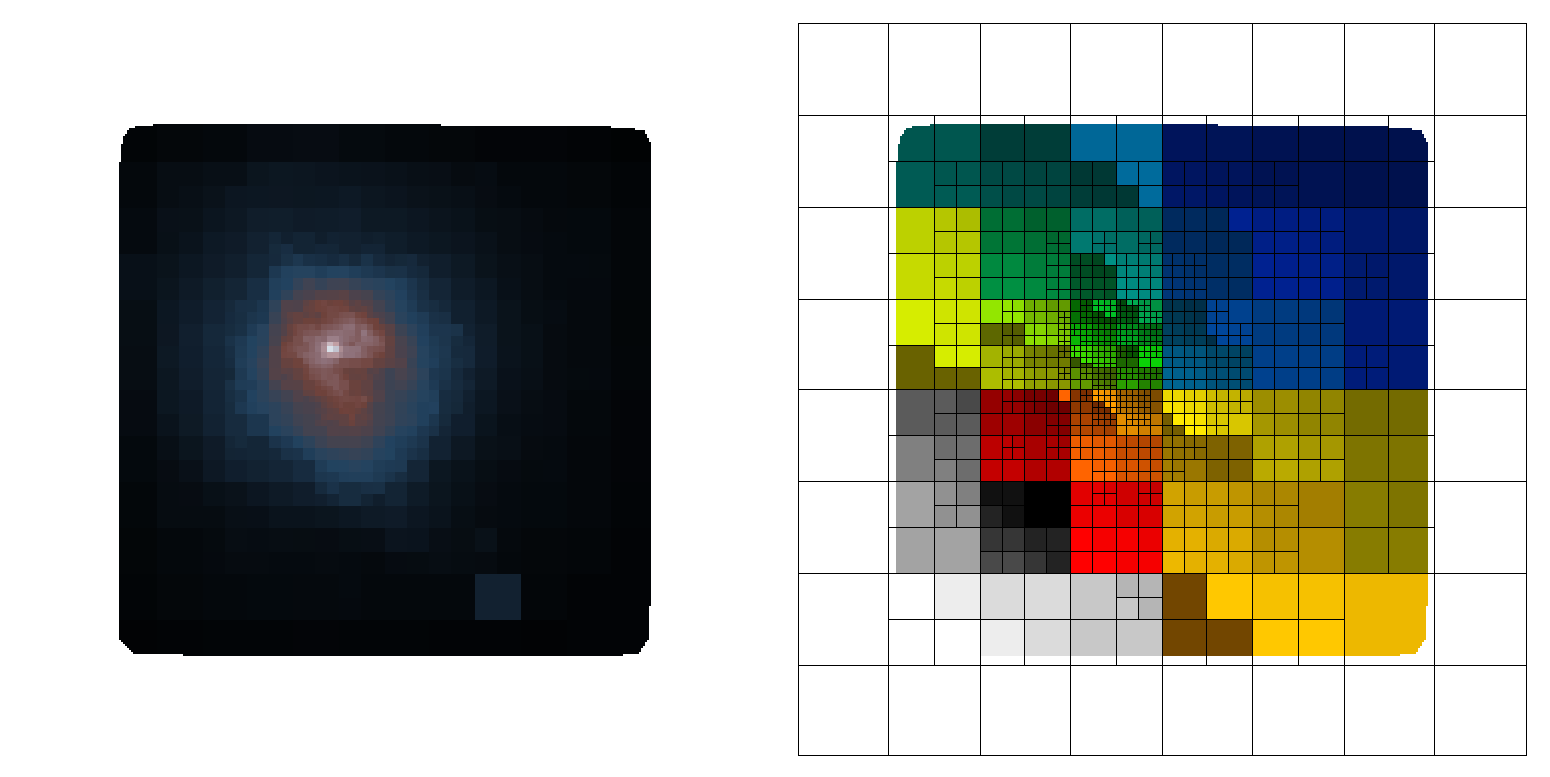

In [47]:
display_map img.rot.abin img.rot.map img.rot.png 

This looks much better.  With the edge of the images aligned with the FOV boundary, the algorithm can 
subdivide the image into 2x2 subgrids.

Now we just need to rotate things back.  We rotate the map back to normal 
sky coordinates, and then create the binned image using `dmmaskbin`

In [48]:
# It is important here that dmregrid2 uses resolution=0 which does not interpolate the map values.
dmregrid2 img.rot.map img.rot.rot.map res=0 method=sum \
  theta=-57.328 rotx=182 roty=183 clob+

dmmaskbin img.fits "img.rot.rot.map[opt type=i4]" img.rot.rot.img clob+

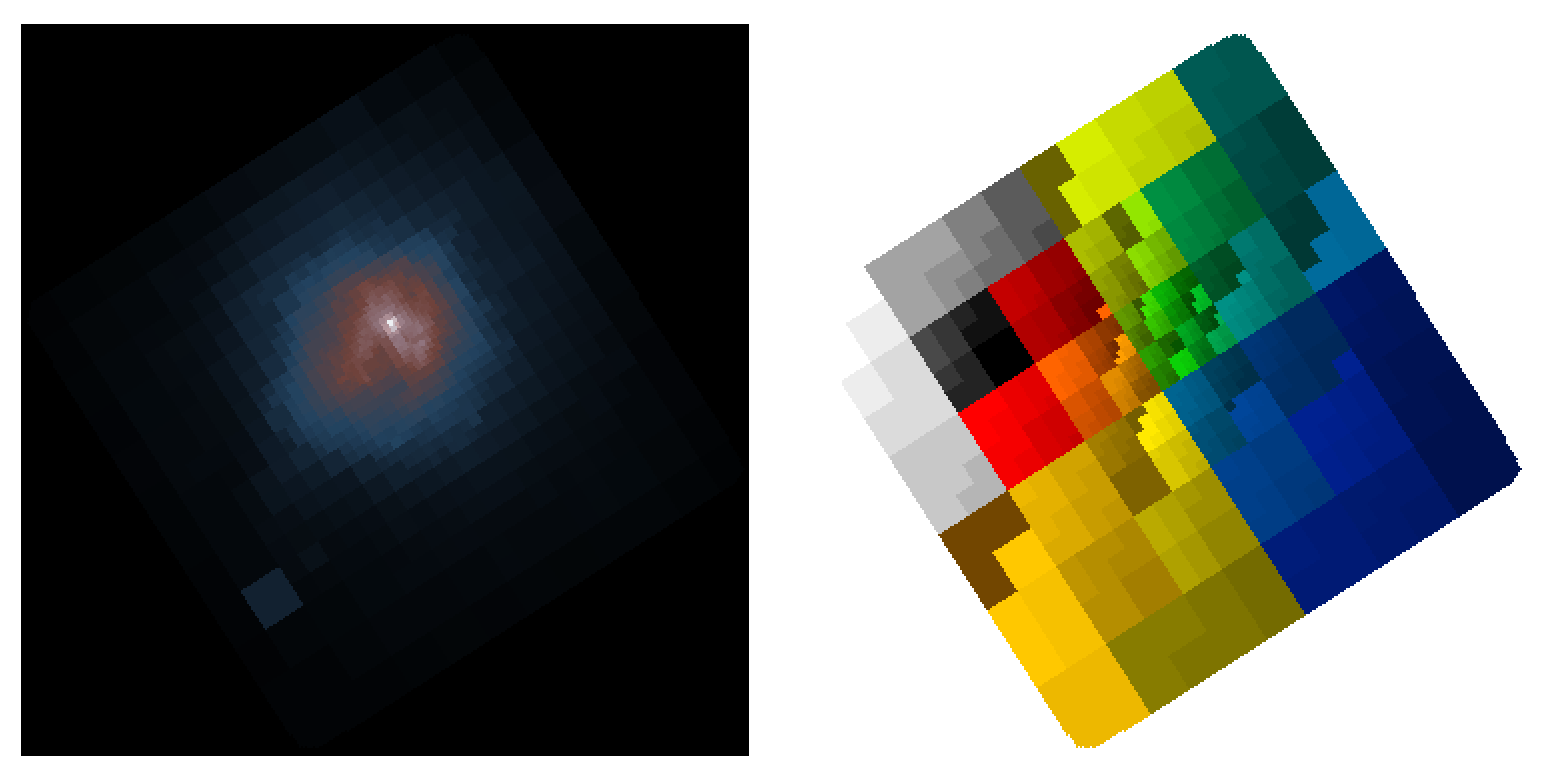

In [49]:
display_map img.rot.rot.img img.rot.rot.map img.rot.rot.png 

The result is a rotated map and rotated groups.


---
## `dmradar` 

Seeing the above image inspired the idea that rather than be restricted to rectangular grids we could also 
implement this type of divide-in-half algorithm using other grids.  The original idea was to use rotated boxes and then 
quickly lead to allowing for a polar grid.

So, `dmradar` does the same thing as `dmnautilus` except instead of dividing the `X` and `Y` axis lengths by 2.0, it
divides the `radius` and `angle`  by 2.0 creating an ellipse (or rotbox) from some input center `X` and `Y` location.

It uses the same `method` parameter in the same way as `dmnautilus`.



```bash
git clone https://github.com/kglotfelty/dmradar
```

Contact me for help building.


### Example 

In this simple example we create a circular polar grid starting 15 physical pixels from the centroid 
(determined using `dmstat`) out to a radius of 2000 physical pixels.  With `method=4`, each
pie slice must have a SNR above 15.8 (~300 counts). 


In [50]:
dmstat smimg.fits cen- verb=0
px=`stk_read_num ")dmstat.out_max_loc" 1 echo+`
py=`stk_read_num ")dmstat.out_max_loc" 2 echo+`

dmradar img.dss.fits radar.4.img 15.8 outmask=radar.4.map method=4 clob+ \
  xcenter="$px" ycenter="$py" \
  shape=pie rstart=15 rstop=2000 clob+

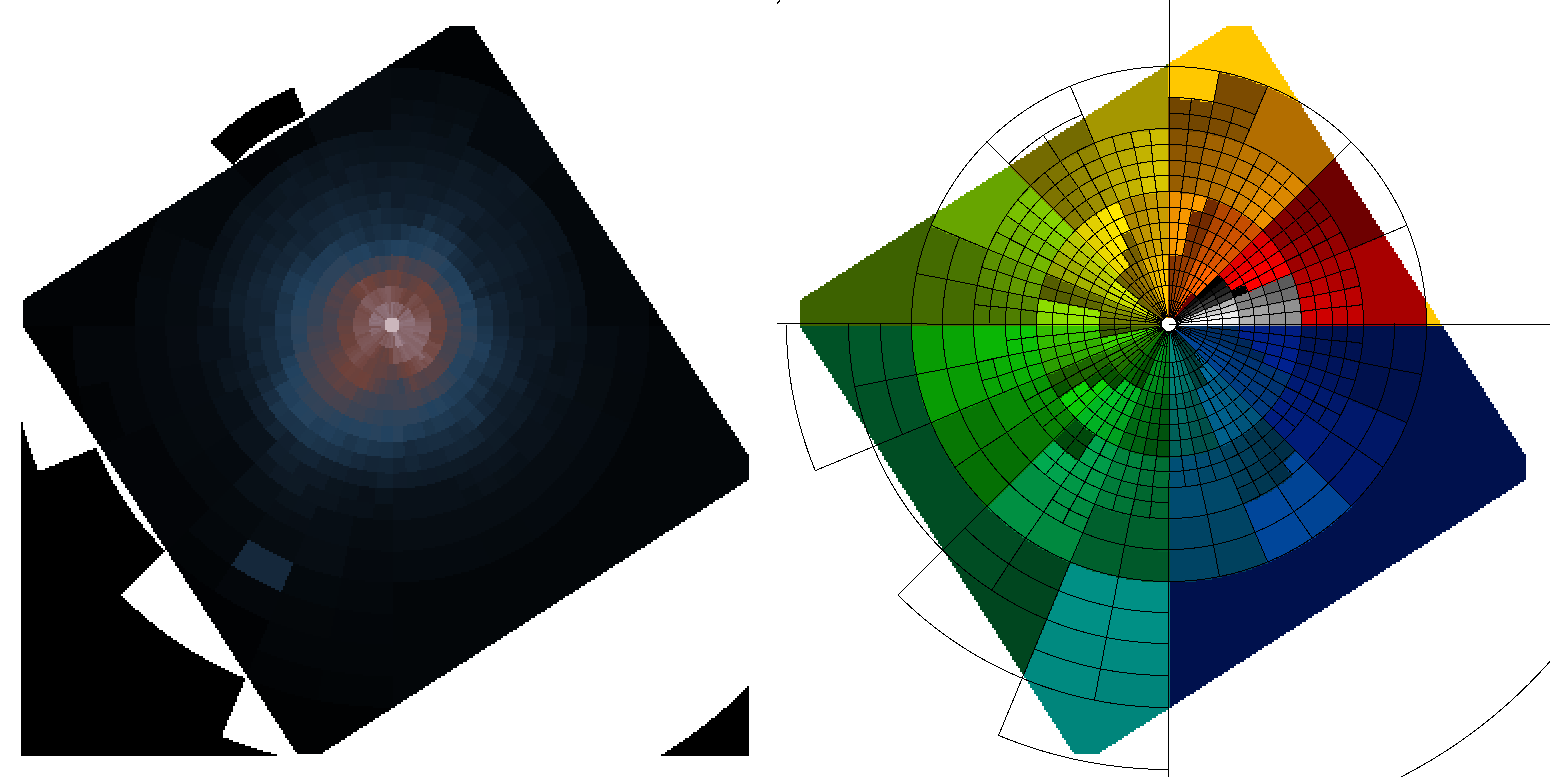

In [51]:
display_map radar.4.img radar.4.map radar.4.png

The output looks somewhat similar to the `mkregmap` example above with the `pgrid()` syntax.  However, this tool
allows the angular width and radius to adjust based on the pixel values.

There are additional parameter to control 

- the starting & ending angles
- the minimum angle and radius size
- the ellipticity (default is 1=circular)
- shape (pie|epanda|bpanda|box).

The `pie` shape is really the same as `epanda` except it runs much faster.  `box` essentially replicates the original
`dmnautilus` behavior, however, 

> Due to numerical precision, there can be gaps in the map.  Fixing this is **TBD**

## `merge_too_small`

As we've seen, there are several algorithms which leave "stranded", isolated pixels ungrouped, or grouped at the end into small, irrelevant groups.

The `merge_too_small` script reassigns those groups to a neighboring group.  Technically this violates the rules used 
to establish the groups, which is why it is a separate script and step in the processing.

"too_small" is defined as either

- `method=area` the number of pixels in the group is below `minvalue`
- `method=counts` the number of counts in the `imgfile` in the group is less than `minvalue`.

`merge_too_small` always reassigns to the adjoining group with the most counts or largest area.


### Example: area too small

We saw in the `pathfinder` example a situation where the grouped contained very few pixels.

We'll use the `merge_too_small` script to merge those smaller contours onto the largest adjoining group.


In [52]:
merge_too_small pathfinder.map pathfinder_min20px.map method=area minval=20  clob+ verb=1 mode=h


merge_too_small
          infile = pathfinder.map
         outfile = pathfinder_min20px.map
          method = area
         imgfile = 
          binimg = 
        minvalue = 20
         verbose = 1
         clobber = yes
            mode = h

Working on mask_id 963 with value 2
Working on mask_id 1019 with value 2
Working on mask_id 787 with value 3
Working on mask_id 959 with value 3
Working on mask_id 1140 with value 3
Working on mask_id 439 with value 4
Working on mask_id 547 with value 4
Working on mask_id 583 with value 4
Working on mask_id 680 with value 4
Working on mask_id 696 with value 4
Working on mask_id 852 with value 4
Working on mask_id 931 with value 4
Working on mask_id 992 with value 4
Working on mask_id 269 with value 5
Working on mask_id 273 with value 5
Working on mask_id 468 with value 5
Working on mask_id 509 with value 5
Working on mask_id 531 with value 5
Working on mask_id 612 with value 5
Working on mask_id 622 with value 5
Working on mask_id 792 with value 

Working on mask_id 934 with value 16
Working on mask_id 1110 with value 16
Working on mask_id 262 with value 17
Working on mask_id 333 with value 17
Working on mask_id 377 with value 17
Working on mask_id 450 with value 17
Working on mask_id 469 with value 17
Working on mask_id 473 with value 17
Working on mask_id 480 with value 17
Working on mask_id 606 with value 17
Working on mask_id 658 with value 17
Working on mask_id 681 with value 17
Working on mask_id 766 with value 17
Working on mask_id 777 with value 17
Working on mask_id 944 with value 17
Working on mask_id 1005 with value 17
Working on mask_id 1118 with value 17
Working on mask_id 1171 with value 17
Working on mask_id 128 with value 18
Working on mask_id 287 with value 18
Working on mask_id 375 with value 18
Working on mask_id 419 with value 18
Working on mask_id 423 with value 18
Working on mask_id 426 with value 18
Working on mask_id 459 with value 18
Working on mask_id 475 with value 18
Working on mask_id 557 with value 

In [53]:
dmimgcalc pathfinder_min20px.map pathfinder.map pathfinder.diff.map sub clob+

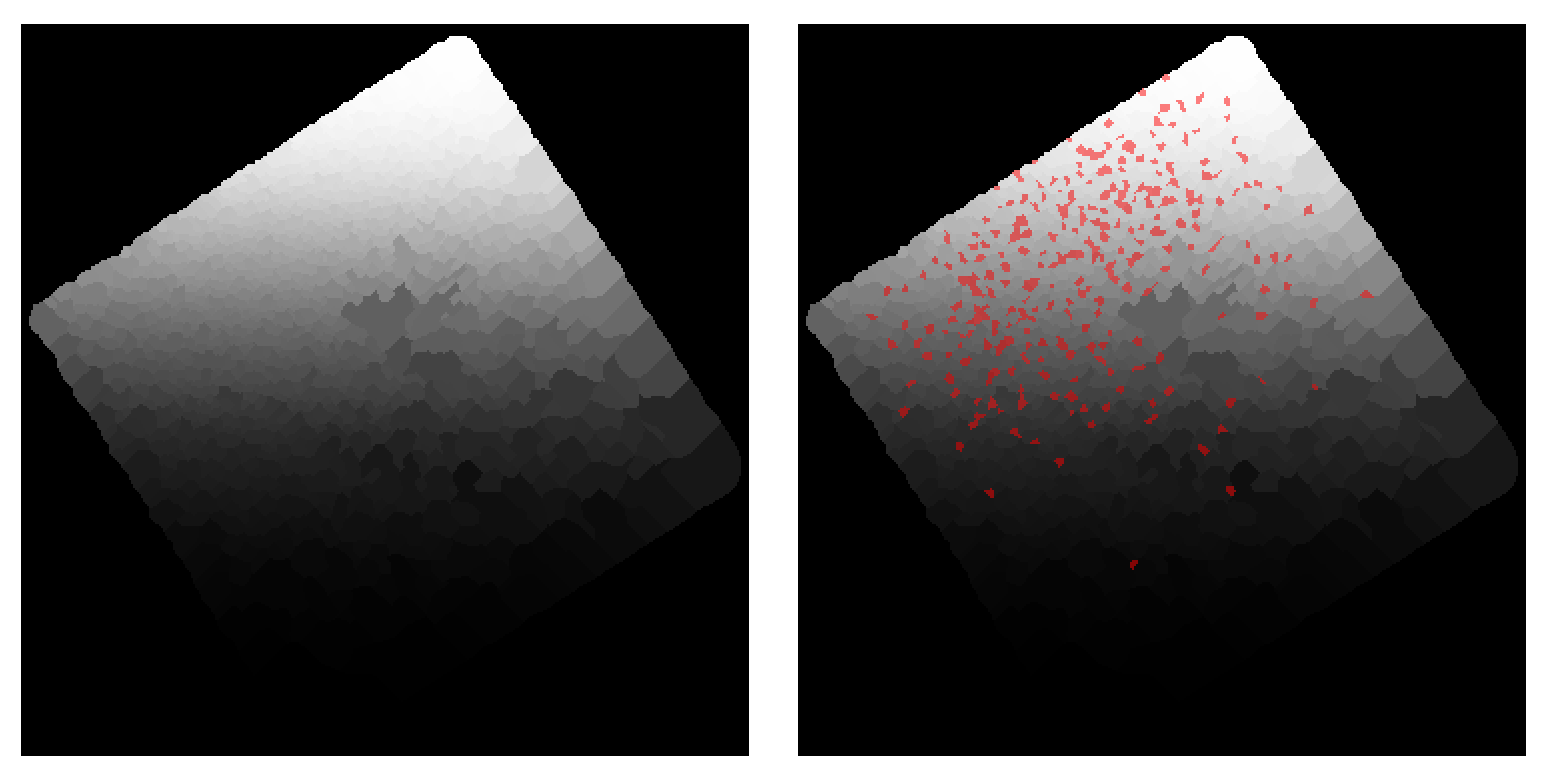

In [54]:
ds9 -geom 1550x824 -zoom 2 \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  pathfinder.map pathfinder_min20px.map  \
  -tile yes \
  -mask transparency 50 -mask color red \
  -mask pathfinder.diff.map \
  -saveimage png p_small_area.png -exit

display < p_small_area.png

Left is the original output from `pathfinder`, Right is after adjusting the grouping to have a min of 20 pixels in each group.  The diff is shaded in red.

### Example 2 : min counts

In [55]:
merge_too_small pathfinder_min20px.map pathfinder_min20px_min300cts.map \
  method=counts imgfile=img.fits binimg=pathfinder_min20px_min300cts.img minval=300 verb=1 clob+


merge_too_small
          infile = pathfinder_min20px.map
         outfile = pathfinder_min20px_min300cts.map
          method = counts
         imgfile = img.fits
          binimg = pathfinder_min20px_min300cts.img
        minvalue = 300
         verbose = 1
         clobber = yes
            mode = ql

Working on mask_id 781 with value 21
Working on mask_id 877 with value 21
Working on mask_id 589 with value 22
Working on mask_id 917 with value 22
Working on mask_id 1034 with value 22
Working on mask_id 210 with value 37
Working on mask_id 574 with value 41
Working on mask_id 1073 with value 44
Working on mask_id 702 with value 47
Working on mask_id 1001 with value 47
Working on mask_id 285 with value 48
Working on mask_id 1141 with value 49
Working on mask_id 516 with value 50
Working on mask_id 336 with value 51
Working on mask_id 1183 with value 51
Working on mask_id 616 with value 52
Working on mask_id 1173 with value 53
Working on mask_id 394 with value 56
Working on mask_id 578

Working on mask_id 1022 with value 173
Working on mask_id 937 with value 174
Working on mask_id 145 with value 176
Working on mask_id 223 with value 176
Working on mask_id 1168 with value 176
Working on mask_id 869 with value 177
Working on mask_id 975 with value 177
Working on mask_id 1036 with value 177
Working on mask_id 648 with value 178
Working on mask_id 737 with value 178
Working on mask_id 105 with value 179
Working on mask_id 190 with value 179
Working on mask_id 133 with value 180
Working on mask_id 474 with value 180
Working on mask_id 1148 with value 181
Working on mask_id 116 with value 182
Working on mask_id 748 with value 182
Working on mask_id 1026 with value 182
Working on mask_id 163 with value 183
Working on mask_id 482 with value 183
Working on mask_id 530 with value 183
Working on mask_id 953 with value 183
Working on mask_id 490 with value 184
Working on mask_id 645 with value 184
Working on mask_id 90 with value 185
Working on mask_id 1071 with value 185
Working

In [56]:
dmimgcalc pathfinder_min20px.map pathfinder_min20px_min300cts.map pathfinder.diff2.map sub clob+

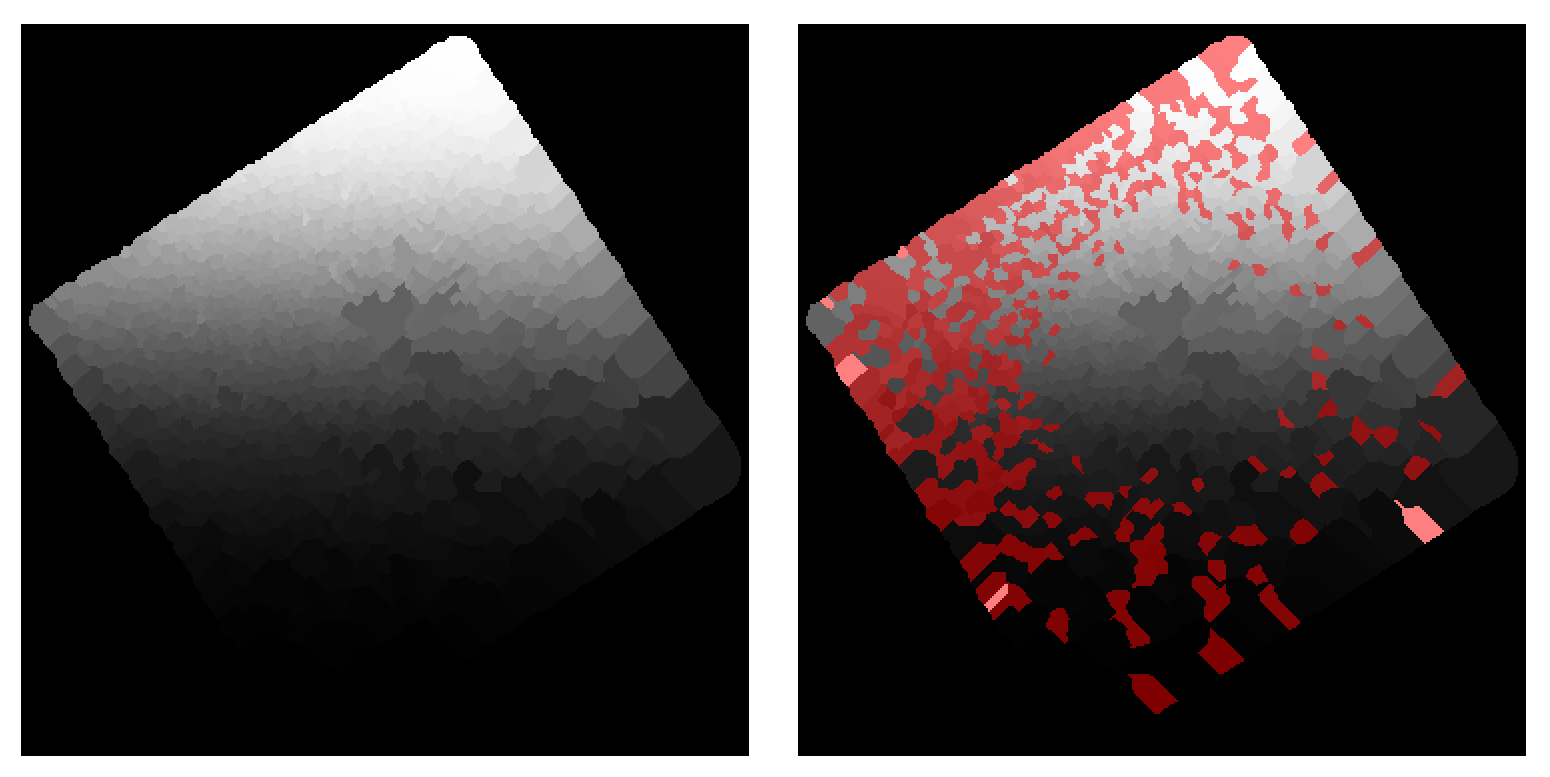

In [57]:
ds9 -geom 1550x824 -zoom 2 \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  pathfinder_min20px.map  pathfinder_min20px_min300cts.map \
  -tile yes \
  -mask transparency 50 -mask color red \
  -mask pathfinder.diff2.map \
  -saveimage png p_small_counts.png -exit

display < p_small_counts.png

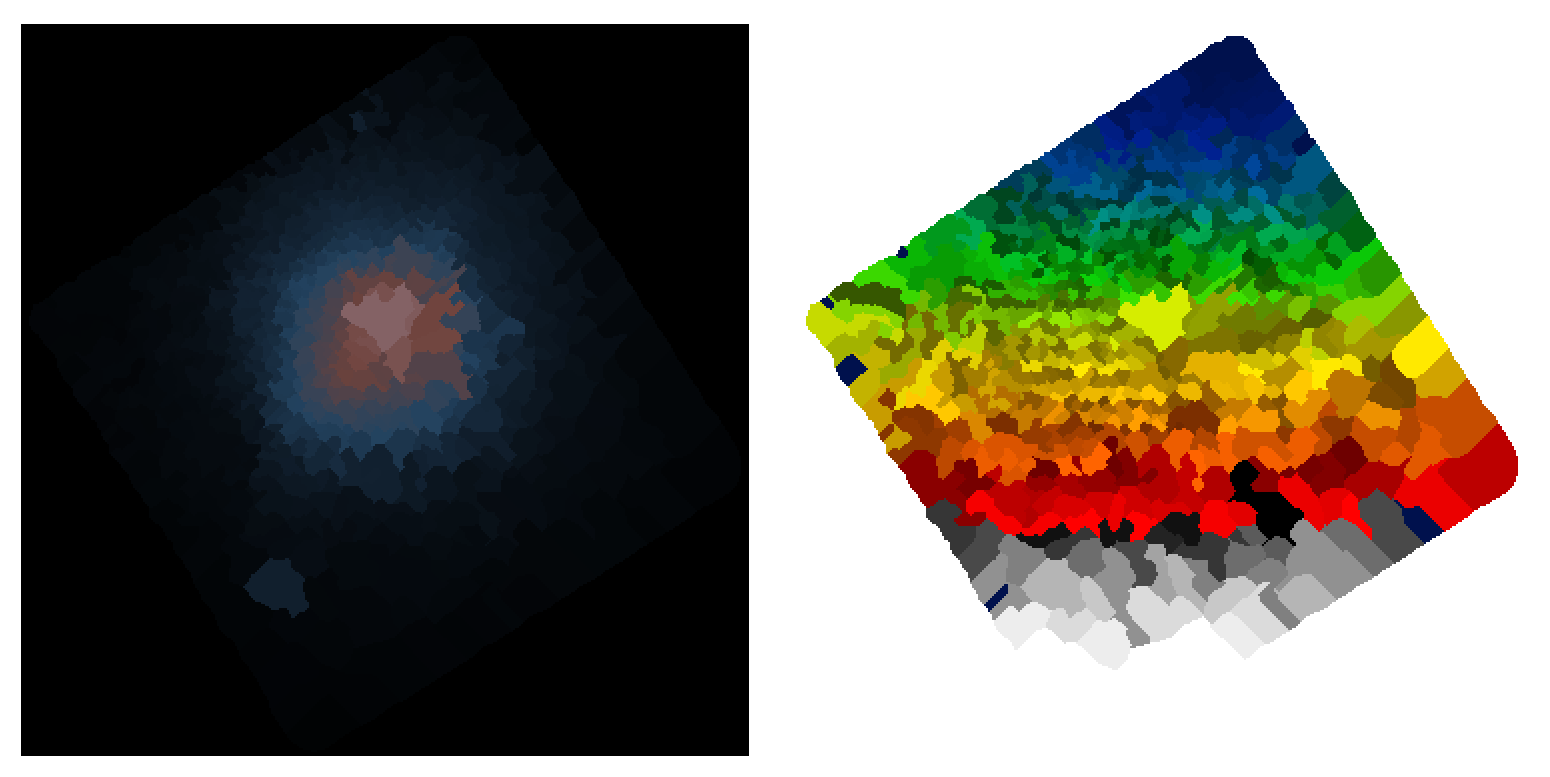

In [58]:
display_map pathfinder_min20px_min300cts.img pathfinder_min20px_min300cts.map pathfinder_min20px_min300cts.png